In [1]:
# %pip install keras
# %pip install --upgrade pip
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the data
data = pd.read_csv('stock_data.csv')

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sort the data by date
data = data.sort_values('Date')

# Reset the index
data = data.reset_index(drop=True)

# Normalize the data
scaler = MinMaxScaler()
data[data.columns[1:]] = scaler.fit_transform(data[data.columns[1:]])

# Display the first few rows of the data
print(data.head())


        Date      Open      High       Low     Close  Adj Close    Volume
0 2018-05-02  0.145680  0.143827  0.172614  0.157992   0.112506  0.177709
1 2018-05-03  0.135721  0.134558  0.158223  0.155715   0.110420  0.311981
2 2018-05-04  0.132773  0.148262  0.166369  0.169061   0.122648  0.190757
3 2018-05-07  0.154165  0.153176  0.185609  0.172594   0.125885  0.094192
4 2018-05-08  0.152611  0.150419  0.181885  0.172594   0.125885  0.126977


In [3]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Select the features and target
features = ['Open', 'High', 'Low', 'Volume']
target = 'Adj Close'

X_train = train_data[features]
y_train = train_data[target]

# Define the hyperparameters for the grid search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rfr = RandomForestRegressor(random_state=0)

# Initialize the grid search
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Get the best model
best_rfr = grid_search.best_estimator_

# Evaluate the model on the training data
train_pred = best_rfr.predict(X_train)
train_mse = mean_squared_error(y_train, train_pred)
print(f'Training MSE: {train_mse}')


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'min_samples_leaf': 1, 'n_estimators': 200}
Training MSE: 1.6035290975093102e-05


In [5]:
# Create the test set
X_test = test_data[features]
y_test = test_data[target]

# Make predictions on the test set
test_pred = best_rfr.predict(X_test)


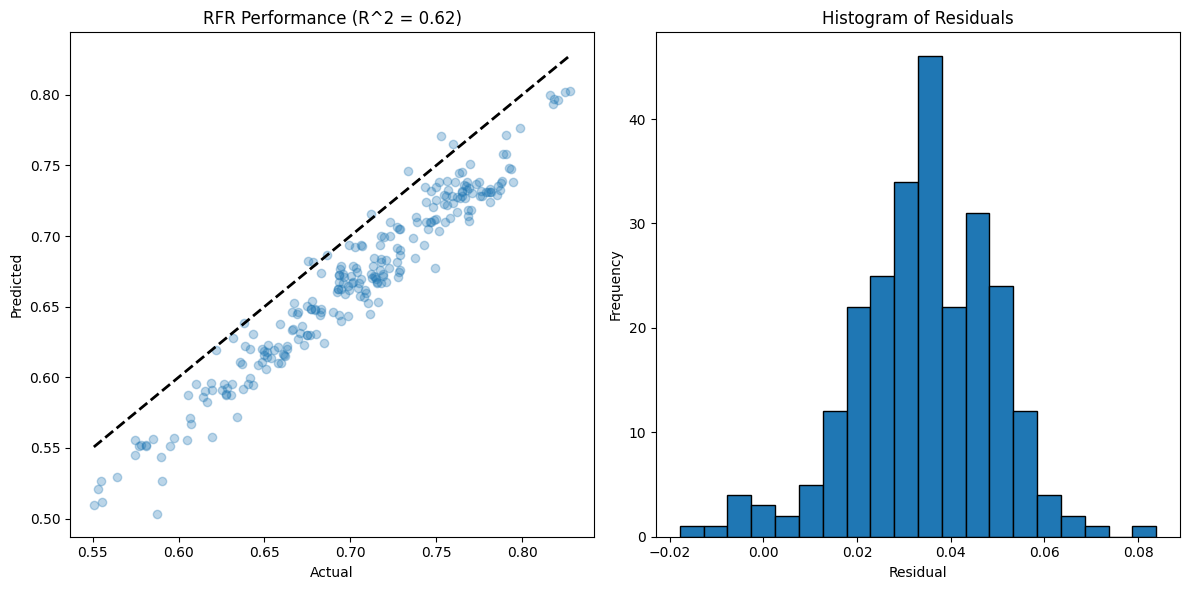

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test, test_pred)

# Create a figure with two subplots: one for the scatter plot and one for the histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot
ax1.scatter(y_test, test_pred, alpha=0.3)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title(f'RFR Performance (R^2 = {r2:.2f})')

# Histogram of residuals
residuals = y_test - test_pred
ax2.hist(residuals, bins=20, edgecolor='k')
ax2.set_xlabel('Residual')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Residuals')

# Show the figure
plt.tight_layout()
plt.show()


In [7]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)


RandomForestRegressor()

In [8]:
#LSTM

In [9]:
import numpy as np
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)


In [10]:
seq_length = 5  # choose sequence length

X_train, y_train = create_sequences(train_data.values, seq_length)
X_test, y_test = create_sequences(test_data.values, seq_length)


In [11]:
# Exclude the 'Date' column
data_no_date = data.drop(columns='Date')

# Split the data into training and testing sets
train_size = int(len(data_no_date) * 0.8)
train_data = data_no_date[:train_size]
test_data = data_no_date[train_size:]

# Create sequences from the training and testing data
seq_length = 5  # choose sequence length
X_train, y_train = create_sequences(train_data.values, seq_length)
X_test, y_test = create_sequences(test_data.values, seq_length)


In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Define the optimizer with a lower learning rate
optimizer = Adam(lr=0.001)


# Exclude the 'Date' column
data_no_date = data.drop(columns='Date')

# Split the data into training and testing sets
train_size = int(len(data_no_date) * 0.8)
train_data = data_no_date[:train_size]
test_data = data_no_date[train_size:]

# Create sequences from the training and testing data
seq_length = 60  # updated sequence length
X_train, y_train = create_sequences(train_data.values, seq_length)
X_test, y_test = create_sequences(test_data.values, seq_length)

# Define the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))  # updated number of LSTM units
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])  # updated number of epochs


Epoch 1/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0487 - val_loss: 0.0381
Epoch 2/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0274 - val_loss: 0.0379
Epoch 3/100
30/30 [==============================] - 0s 14ms/step - loss: 0.0272 - val_loss: 0.0379
Epoch 4/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0272 - val_loss: 0.0380
Epoch 5/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0272 - val_loss: 0.0380
Epoch 6/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0272 - val_loss: 0.0379
Epoch 7/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0272 - val_loss: 0.0379
Epoch 8/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0272 - val_loss: 0.0379
Epoch 9/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0272 - val_loss: 0.0379
Epoch 10/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0272 - val_loss: 0.0380

In [13]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, 0]  # select the first feature as the target
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# Create sequences from the training and testing data
X_train, y_train = create_sequences(train_data.values, seq_length)
X_test, y_test = create_sequences(test_data.values, seq_length)


In [14]:
# Make predictions on the test data
test_pred = model.predict(X_test)

# Reshape test_pred to a 1D array
test_pred = test_pred.reshape(-1)

# Calculate R-squared
r2 = r2_score(y_test, test_pred)


6/6 [==============================] - 0s 4ms/step


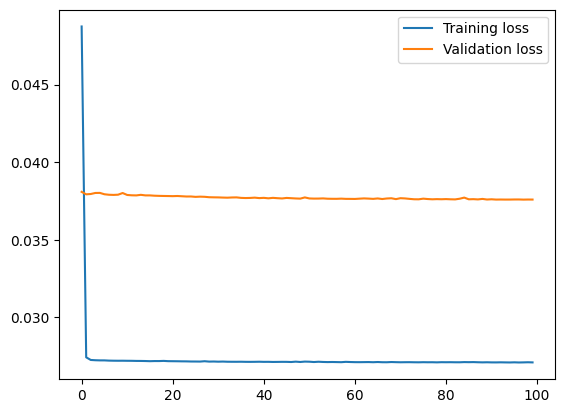

In [15]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


6/6 [==============================] - 0s 6ms/step


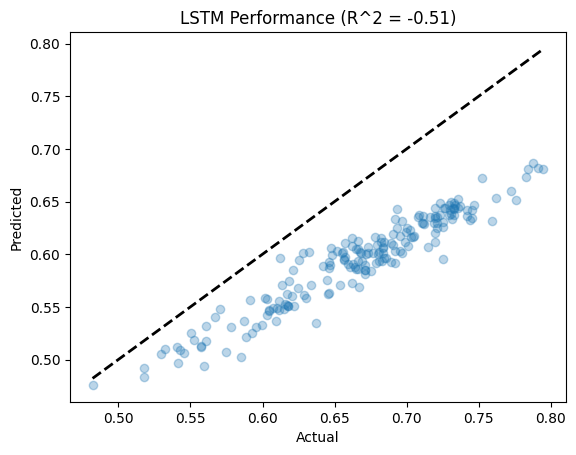

In [16]:
# Make predictions on the test data
test_pred = model.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, test_pred)

# Create a scatter plot of actual vs predicted values
plt.scatter(y_test, test_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'LSTM Performance (R^2 = {r2:.2f})')
plt.show()


In [17]:
### SENTIMENT ANALYSIS

%pip install newsapi


Note: you may need to restart the kernel to use updated packages.


In [18]:
# from newsapi import NewsApiClient

# # Init
# newsapi = NewsApiClient(api_key='#Enter Your API Key#')

# # /v2/everything
# all_articles = newsapi.get_everything(q='SPY',
#                                       language='en',
#                                       sort_by='relevancy',
#                                       page=1)

# # Extract the news articles from the response
# news = all_articles["articles"]

# # Store the news titles in a list
# news_list = [news_item["title"] for news_item in news]

# from textblob import TextBlob

# # Function to perform sentiment analysis
# def sentiment_analysis(news):
#     analysis = TextBlob(news)
#     if analysis.sentiment.polarity > 0:
#         return "positive"
#     elif analysis.sentiment.polarity == 0:
#         return "neutral"
#     else:
#         return "negative"

# # Perform sentiment analysis on each news article
# sentiments = [sentiment_analysis(news) for news in news_list]
# import pandas as pd

# # Create a DataFrame with the news articles and their sentiments
# df = pd.DataFrame({"news": news_list, "sentiment": sentiments})

# import matplotlib.pyplot as plt

# # Plot the sentiment distribution
# df["sentiment"].value_counts().plot(kind='bar')
# plt.xlabel("Sentiment")
# plt.ylabel("Count")
# plt.title("Sentiment Distribution of GOOG News")
# plt.show()

In [19]:
##### LINEAR REGRESSION

Intercept: -76973.74540532747
Coefficients: [0.10481763]
Mean Squared Error: 1259.5925480765197


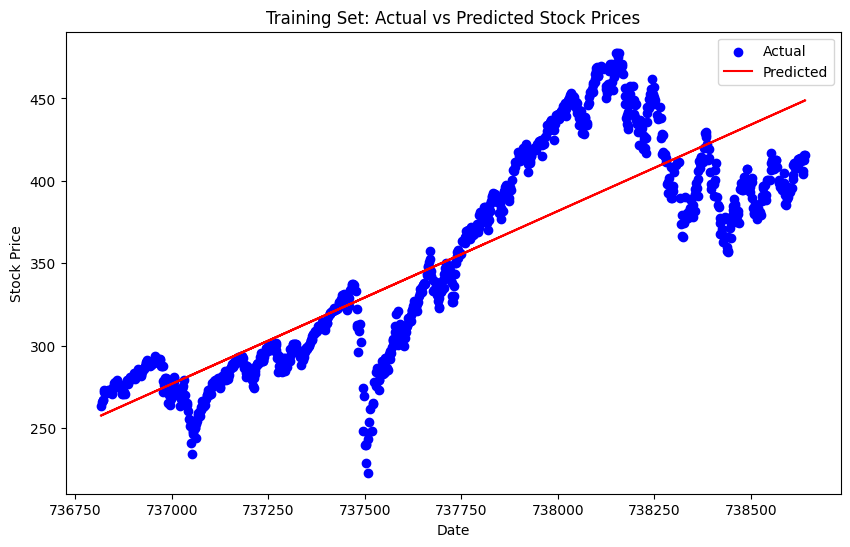

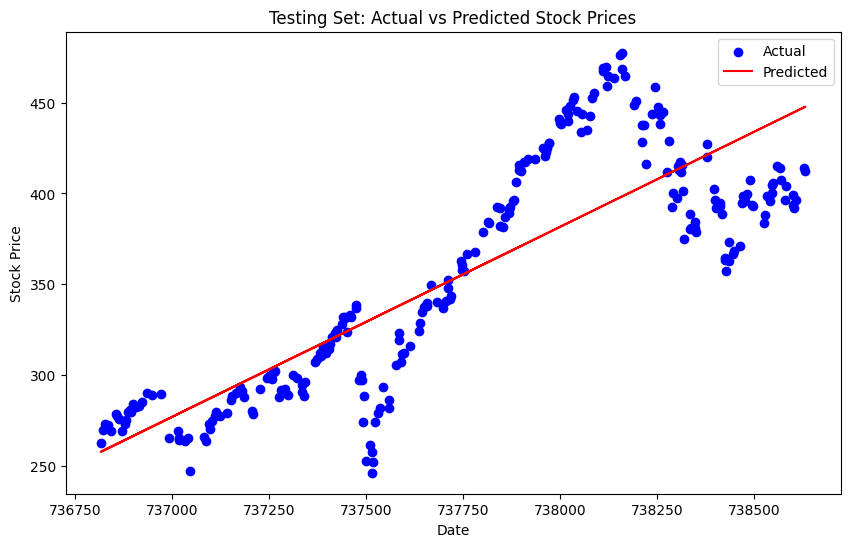

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt

# Load the data
data = pd.read_csv('stock_data.csv')

# Convert the 'Date' column into ordinal values
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].map(dt.datetime.toordinal)

# Split the data into feature (X) and target (y) sets
X = data[['Date']]
y = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Print the intercept and coefficients of the model
print(f'Intercept: {model.intercept_}')
print(f'Coefficients: {model.coef_}')

# Use the model to predict the stock prices on the testing set
y_pred = model.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot the actual vs predicted stock prices for the training set
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Actual')
plt.plot(X_train, model.predict(X_train), color='red', label='Predicted')
plt.title('Training Set: Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot the actual vs predicted stock prices for the testing set
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', label='Predicted')
plt.title('Testing Set: Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [21]:
#saving the models

In [22]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

# Define LSTM model
lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=50, return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=25))
lstm.add(Dense(units=1))

# Compile the model
lstm.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
lstm.fit(x=X_train, y=y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])


Epoch 1/100
32/32 [==============================] - 2s 11ms/step - loss: 127568.9922 - val_loss: 128751.1719
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 123436.7422 - val_loss: 121318.4062
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 112514.4219 - val_loss: 106083.2031
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 94981.8438 - val_loss: 86232.8594
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: 75328.7109 - val_loss: 66129.7266
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 56345.0586 - val_loss: 48109.1289
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 39980.8789 - val_loss: 33360.9180
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 27615.1523 - val_loss: 22177.9766
Epoch 9/100
32/32 [==============================] - 0s 1ms/step - loss: 18294.8398 - val_loss: 14393.0264
Epoch 10/100
32/32 [==========

In [23]:
from sklearn.linear_model import LinearRegression

# Define Linear Regression model
lr = LinearRegression()

# Fit the model
lr.fit(X_train, y_train)


LinearRegression()

In [24]:
#REINFORCEMENT LEARNING

In [25]:
models = [rfr, lstm, lr]
feature_names = ['Open', 'High', 'Low', 'Volume']


In [26]:
from stable_baselines3 import A2C
import gym
from gym import spaces
import numpy as np
from tensorflow import keras


class WeightAssignmentEnv(gym.Env):
    def __init__(self, models, data):
        super(WeightAssignmentEnv, self).__init__()
        self.models = models
        self.data = data
        self.reward_range = (-np.inf, np.inf)
        self.action_space = spaces.Box(low=0, high=1, shape=(len(models),))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(data.shape[1],))
        self.current_step = 0

    def step(self, action):
        self.current_step += 1
        if self.current_step >= len(self.data):
            done = True
            state = self.data.iloc[-1]
        else:
            done = False
            state = self.data.iloc[self.current_step]
        reward = self.calculate_reward(action)
        return state, reward, done, {}

    def reset(self):
        self.current_step = 0
        return self.data.iloc[self.current_step]

    def calculate_reward(self, action):
        weights = action / np.sum(action)  # Normalize action values to sum to 1
        features = self.data.iloc[self.current_step][feature_names]  # Select only the features used for training
        predictions = []
        for model in self.models:
            if isinstance(model, keras.models.Sequential):  # If the model is an LSTM model
                # Reshape the input data to (None, 1, 1)
                prediction = model.predict(features.values.reshape(1, 1, 1))
            else:
                prediction = model.predict(features.values.reshape(1, -1))
            predictions.append(prediction)
        predictions = np.array(predictions)
        weighted_prediction = np.dot(weights, predictions)
        actual_value = self.data.iloc[self.current_step]['Adj Close']
        reward = -np.square(actual_value - weighted_prediction)  # Negative mean squared error
        return reward





# Create the environment
env = WeightAssignmentEnv(models, data)

# Initialize the A2C model
model = A2C('MlpPolicy', env, verbose=1)

# Train the model
model.learn(total_timesteps=10000)


In [ ]:
## KERAS LSTM NETWORK 
# %pip install keras-models
%pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 859.2 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import graphviz

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(10000, features)))
model.add(LSTM(50))
model.add(Dense(1))

# Generate a graph of the model architecture
dot = graphviz.Digraph()
dot.node('Input', shape='box')
dot.node('LSTM1', shape='box')
dot.node('LSTM2', shape='box')
dot.node('Dense', shape='box')
dot.edge('Input', 'LSTM1')
dot.edge('LSTM1', 'LSTM2')
dot.edge('LSTM2', 'Dense')
dot.node('Output', shape='box')
dot.edge('Dense', 'Output')

# Save the graph as an image file
dot.format = 'png'
dot.render('lstm_model', view=False)


In [27]:
# List of different numbers of timesteps to try
timesteps = [5000, 10000, 20000, 50000]

# Initialize a list to store the results
results = []

# For each number of timesteps
for t in timesteps:
    # Initialize the A2C model
    model = A2C('MlpPolicy', env, verbose=1)

    # Train the model
    model.learn(total_timesteps=t)

    # Evaluate the model
    obs = env.reset()
    for i in range(1000):
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        if done:
            break

    # Store the total reward
    results.append(rewards.sum())

# Plot the results
plt.plot(timesteps, results)
plt.xlabel('Number of timesteps')
plt.ylabel('Total reward')
plt.show()
